In [2]:
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb
import pickle
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from collections import Counter as cnt
import tensorflow as tf

Using TensorFlow backend.


In [3]:
%store -r mc_data

In [4]:
# Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event
14   hasT
15   isInUT
16   isInVelo
17   isLong
18   isLong_fromB
19   isLong_fromB_more5
20   isLong_more5


In [5]:
mc_hits = mc_data.values

In [5]:
booster = xgb.Booster({'nthread':4}) #init model
booster.load_model('./models/xgboost_two_seeds_validation') # load data

In [6]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    seed_station_validation = load_model('./models/seed_station_validation_v2.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    two_seeds_validation = load_model('./models/two_seeds_validation.h5')

In [8]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    seeds_validation = load_model('./models/track_classifier_all_stations_99_=9-=0.h5')

In [9]:
%store -r zLays
%store -r max_x
%store -r min_x
%store -r max_y
%store -r min_y
%store -r events
%store -r notValidParticles

In [55]:
print(notValidParticles)

[11, 1000010020, 1000010030, 1000020030, 1000020040]


In [12]:
def histogram(data, color, alphaValue, min, max, title, x_axis, y_axis):
    fig = plt.figure(figsize=(19, 10))
    ax = fig.add_subplot(111)
    
    textstr = '$\mu=%.3f$\n$\sigma=%.3f$\n$n=%.0f$'%(np.mean(np.array(data)), np.std(np.array(data)), len(data))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)

    n, bins, patches = plt.hist(data, 100, facecolor=color, range=(min,max), alpha=alphaValue)
    ax.set_title('%s\n' % title, fontsize=14)
    ax.set_xlabel(x_axis,fontsize=14)
    ax.set_ylabel(y_axis,fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    ax.grid()
    plt.show()

In [29]:
def predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer):
    
    z_stereo = zLays[stereo_layer]
    
    if (stereo_layer % 2 != 0):
        angle = 5
    else:
        angle = -5
        
    if (float(x3 - x0)  == 0):
        m = 1
    else:
        m = float(zLays[last_layer] - zLays[first_layer]) / float(x3 - x0)
    n = zLays[last_layer] - (m * x3)
    
    x_pred = (z_stereo - n) / m 
    beta = (x_pred - x_stereo) / (math.radians(angle) * z_stereo)
    return math.tan(beta) * z_stereo

In [17]:
hit = mc_hits[0]

print(predictHeight(mc_hits[1][5][0], mc_hits[1][5][3], mc_hits[1][5][1], 1, 0, 3))

-0.002257354415791495
195.8993018292117


In [8]:
mc_hits[1]

array([211,
       list([-459.2020568848, -470.9031677246, -482.6800231934, -494.5126953125, -575.563293457, -587.751159668, -599.9672241211, -612.2156982422, -696.1311035156, -708.5855102539, -721.0521240234, -733.5468139648]),
       list([196.2071990967, 197.9016876221, 199.5924377441, 201.2675628662, 212.5396575928, 214.2194671631, 215.8995361328, 217.5735626221, 228.9906616211, 230.6494750977, 232.3111724854, 233.953125]),
       list([7826.7060546875, 7896.7124023438, 7966.71875, 8036.7255859375, 8508.7646484375, 8578.771484375, 8648.77734375, 8718.7841796875, 9193.82421875, 9263.830078125, 9333.8369140625, 9403.8427734375]),
       list([296699, 360603, 427785, 491644, 559275, 626402, 626405, 690360, 757445, 821889, 888072, 952970, 1019114, 1019117]),
       list([-459.3350219727, -488.1535644531, -465.2213134766, -494.5150146484, -575.7149658203, -607.1112060547, -606.4838256836, -581.1875610352, -612.1649780273, -696.0149536133, -728.3927001953, -700.9432373047, -733.589965820

In [13]:
def selectValidCombinations(hit, arr_layer1, arr_layer2, arr_layer3, station, predictions):
    
    valid_combinations = []
    
    x0_layer = 0
    if (station == 1):
        x0_layer = 4
    else:
        x0_layer = 8
    u_layer = x0_layer + 1
    v_layer = x0_layer + 2
    x1_layer = x0_layer + 3
    
    if (len(arr_layer3) > 0) and len(arr_layer2) > 0 and len(arr_layer1) > 0:
        
        for h3 in arr_layer3:

            for h2 in arr_layer2:

                # Predict height for each hit selected in the V layer
                pred_h2 = predictHeight(hit[1], h3[1], h2[1], v_layer, x0_layer, x1_layer)

                if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
                    continue

                for h1 in arr_layer1:

                    # Predict height for hit in the U layer
                    pred_h1 = predictHeight(hit[1], h3[1], h1[1], u_layer, x0_layer, x1_layer)

                    if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
                        continue
                        
                    if np.abs(pred_h2 - pred_h1) < 50:
                        seed = [hit[1], h1[1], pred_h1, h2[1], pred_h2, h3[1], station, (hit[3], h1[3], h2[3], h3[3]), (hit[0], h1[0], h2[0], h3[0])]
                        valid_combinations.append(seed)

    else:
        if len(arr_layer3) == 0 and (len(arr_layer2) > 0) and (len(arr_layer1) > 0): 
            for h2 in arr_layer2:
                for h1 in arr_layer1:
                    seed = [hit[1], h1[1], 0, h2[1], 0, predictions[2], station, (hit[3], h1[3], h2[3], 0), (hit[0], h1[0], h2[0], 0)]
                    valid_combinations.append(seed)
        elif len(arr_layer3) == 0 and len(arr_layer2) > 0:
            for h2 in arr_layer2:
                seed = [hit[1], 0, 0, h2[1], 0, predictions[2], station, (hit[3], 0, h2[3], 0), (hit[0], 0, h2[0], 0)]
                valid_combinations.append(seed)
        elif len(arr_layer3) == 0 and len(arr_layer1) > 0:
            for h1 in arr_layer1:
                seed = [hit[1], h1[1], 0, 0, 0, predictions[2], station, (hit[3], h1[3], 0, 0), (hit[0], h1[0], 0, 0)]
                valid_combinations.append(seed)
        elif len(arr_layer1) > 0 and len(arr_layer2) == 0:
            for h3 in arr_layer3:
                for h1 in arr_layer1:
                    pred_h1 = predictHeight(hit[1], h3[1], h1[1], u_layer, x0_layer, x1_layer)

                    if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
                        continue

                    seed = [hit[1], h1[1], pred_h1, 0, 0, h3[1], station, (hit[3], h1[3], 0, h3[3]), (hit[0], h1[0], 0, h3[0])]
                    valid_combinations.append(seed)
        elif len(arr_layer2) > 0 and len(arr_layer1) == 0:
            for h3 in arr_layer3:
                for h2 in arr_layer2:

                    pred_h2 = predictHeight(hit[1], h3[1], h2[1], v_layer, x0_layer, x1_layer)

                    if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
                        continue

                    seed = [hit[1], 0, 0, h2[1], pred_h2, h3[1], station, (hit[3], 0, h2[3], h3[3]), (hit[0], 0, h2[0], h3[0])]
                    valid_combinations.append(seed)
                    
    return valid_combinations

In [14]:
def calculateMinMaxHeight(track):
    if (track[2] == 0 and track[4] == 0):
        min_h = 0
        max_h = 0
    elif track[2] == 0:
        min_h = track[4]
        max_h = track[4]
    elif track[4] == 0:
        min_h = track[2]
        max_h = track[2]
    else:
        if track[2] > track[4]:
            min_h = track[4]
            max_h = track[2]
        else:
            min_h = track[2]
            max_h = track[4]
    return min_h, max_h

In [15]:
def validateThreeTracks(track1, track2, track3):
    found = 0
    
    listTrack1 = track1[7]
    listTrack2 = track2[7]
    listTrack3 = track3[7]
    
    for num1 in listTrack1:
        
        if listTrack1.count(num1) < 2 or listTrack2.count(num1) < 2 or listTrack3.count(num1) < 2:
            continue
        
        found = 0
        if track1[7][1] == num1 or track1[7][2] == num1 and track1[7][0] == num1 or track1[7][3] == num1:
            found += 1
        if track2[7][0] == num1 or track2[7][3] == num1 and track2[7][1] == num1 or track2[7][2] == num1:
            found += 1
        if track3[7][0] == num1 or track3[7][3] == num1 and track3[7][1] == num1 or track3[7][2] == num1:
            found += 1
        if found > 2:
            return True
                
    return False

In [16]:
def validateTracks(track1, track2):
    found = 0
    
    listTrack1 = track1[7]
    listTrack2 = track2[7]
    
    for num1 in listTrack1:
        
        if listTrack1.count(num1) < 2 or listTrack2.count(num1) < 2:
            continue
        
        found = 0
        if track1[7][1] == num1 or track1[7][2] == num1 and track1[7][0] == num1 or track1[7][3] == num1:
            found += 1
        if track2[7][0] == num1 or track2[7][3] == num1 and track2[7][1] == num1 or track2[7][2] == num1:
            found += 1
        if found > 1:
            return True
                
    return False

In [17]:
def selectValidSeed(seed1, list_seeds):
    max = 0
    sel = None
    if (len(list_seeds) > 0):
        sel = list_seeds[0]
        for seed in list_seeds:
            pred = two_seeds_validation.predict(np.concatenate((seed1[:7],seed[0][:7])).reshape(1,-1))[0][0]
            if pred > max:
                max = pred
                sel = seed
    return sel, max

In [18]:
def selectValidSeedsForTrack(seed1, seed2, list_seeds):
    max = 0
    sel = None
    if (len(list_seeds) > 0):
        sel = list_seeds[0]
        for seed in list_seeds:
            pred = seeds_validation.predict(np.concatenate((seed1[:6],seed2[:6], seed[0][:6])).reshape(1,-1))[0][0]
            if pred > max:
                max = pred
                sel = seed
    return sel, max

In [19]:
def stationIds(station):
    x0_layer = 0
    if (station == 1):
        x0_layer = 4
    elif (station == 2):
        x0_layer = 8
        
    u_layer = x0_layer + 1
    v_layer = x0_layer + 2
    x1_layer = x0_layer + 3
    return x0_layer, u_layer, v_layer, x1_layer

In [20]:
def sortTrack(track, compare):
    if (track[2] == 0):
        return np.abs(track[4] - compare)
    else:
        return np.abs(track[2] - compare)

In [21]:
def checkHitsSelected(seed, selected):
    found = 0
    if seed[8][0] in selected:
        found += 1
    if seed[8][1] in selected:
        found += 1        
    if seed[8][2] in selected:
        found += 1    
    if seed[8][3] in selected:
        found += 1
    return found > 2

In [22]:
def addHitsSelected(seed, selected):
    selected[seed[8][0]] = 1
    selected[seed[8][1]] = 1
    selected[seed[8][2]] = 1
    selected[seed[8][3]] = 1

In [23]:
def particleIdFromTracks(track1, track2, track3):
    num1 = np.argmax(np.bincount(track1[7]))
    num2 = np.argmax(np.bincount(track2[7]))
    num3 = np.argmax(np.bincount(track3[7]))
    if (num1 == num2 and num1 == num3) or num1 == num3 or num1 == num2:
        return num1
    if num2 == num3:
        return num2
    return -1

In [24]:
def particleIdFromTwoSeeds(seed1, seed2):
    found = 0
    
    listSeed1 = seed1[7]
    listSeed2 = seed2[7]
    
    for num1 in listSeed1:
        
        if listSeed1.count(num1) < 2 or listSeed2.count(num1) < 2:
            continue
        
        found = 0
        if seed1[7][1] == num1 or seed1[7][2] == num1 and seed1[7][0] == num1 or seed1[7][3] == num1:
            found += 1
        if seed2[7][0] == num1 or seed2[7][3] == num1 and seed2[7][1] == num1 or seed2[7][2] == num1:
            found += 1
        if found > 1:
            return num1
                
    return -1

In [25]:
def areNearSeeds(seed1, seed2):
    probability = 0
    if np.abs(seed1[0] - seed2[0]) < 3:
        probability += 1
    if np.abs(seed1[1] - seed2[1]) < 3:
        probability += 1
    if np.abs(seed1[3] - seed2[3]) < 3:
        probability += 1
    if np.abs(seed1[5] - seed2[5]) < 3:
        probability += 1
    return probability > 1   

In [80]:
#
# Test the NN model by using events not feeded as train 
#
max_hits_gathered = 15

def seedStation(station):
    
    # Variable defining the maximum number of hits gathered from the R-trees when using the predicted value from the NN
    found_total = 0
        
    x0_layer, u_layer, v_layer, x1_layer = stationIds(station)
    
    limit = 200
        
    max_hits_gathered = 30
        
    hits_station = list(hit_tree.intersection((min_x, max_x, x0_layer, x0_layer, 0, 1), objects='raw'))
        
    for i in range(0, len(hits_station)):
        
        hit = hits_station[i]
        
        valid_tracks = []
        first_hit = hit[1]
        zone = hit[2]
        m = zLays[x0_layer] / first_hit
        n = zLays[x0_layer] - (m * first_hit)
        
        predicted = np.zeros(3)
        predicted[0] = (zLays[u_layer] - n) / m 
        predicted[1] = (zLays[v_layer] - n) / m 
        predicted[2] = (zLays[x1_layer] - n) / m 
        
        sem_hits_index.acquire()
        arr_layer1 = list(hit_tree.intersection((predicted[0] - limit, predicted[0] + limit, u_layer, u_layer, zone, zone), objects='raw'))
        sem_hits_index.release()

        arr_layer1 = sorted(arr_layer1, key=lambda x: np.abs(x[0]- predicted[0]))[:max_hits_gathered]
        
        sem_hits_index.acquire()
        arr_layer2 = list(hit_tree.intersection((predicted[1] - limit, predicted[1] + limit, v_layer, v_layer, zone, zone), objects='raw'))
        sem_hits_index.release()
        
        arr_layer2 = sorted(arr_layer2, key=lambda x: np.abs(x[0]- predicted[1]))[:max_hits_gathered]

        sem_hits_index.acquire()
        found = list(hit_tree.intersection((predicted[2] - limit, predicted[2] + limit, x1_layer, x1_layer, zone, zone), objects='raw'))
        sem_hits_index.release()
        
        found = sorted(found, key=lambda x: np.abs(x[0]- predicted[2]))[:max_hits_gathered]

        valid_combinations = selectValidCombinations(hit, arr_layer1, arr_layer2, found, station, predicted)
        
        if len(valid_combinations) > 0:
            
            alreadyFound = False
            for val in valid_combinations:
                sem_model.acquire()
                with graph.as_default():
                    acc = seed_station_validation.predict(np.array([val[:7]]).reshape(1,-1))[0][0]
                sem_model.release()
                
                if acc > 0.2:
                    min_h, max_h = calculateMinMaxHeight(val)
                    sem_seeds_index.acquire()
                    seed_tree.insert(int(hit[1]), (hit[1], hit[1], min_h, max_h, station, station), [val, hash(str(val))])
                    sem_seeds_index.release()
                
                if not alreadyFound:
                    found = 0
                    if val[7][0] == val[7][2] or val[7][0] == val[7][1]:
                        found += 1
                    if val[7][0] == val[7][3]:
                        found += 1
                    if val[7][3] == val[7][2] or val[7][3] == val[7][1]:
                        found += 1
                    if found > 1:
                        alreadyFound = True
                        found_total += 1
            
    seeds_found[station] = found_total/length_valid

In [81]:
##### import time
import threading
import time
from multiprocessing.dummy import Pool as ThreadPool 
sem_model = threading.Lock()
sem_hits_index = threading.Lock()
sem_seeds_index = threading.Lock()

total_seed_mean = done = total_mean = ghosts = 0

p_hits = index.Property()
p_hits.dimension = 3

test_events = events[:100]
total_number = len(test_events)

graph = tf.get_default_graph()

for event in test_events:
    
    if event == 15863 or event == 15862:
        continue
    
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    
    hit_tree = index.Index(properties=p_hits, interleaved=False)
    seed_tree = index.Index(properties=p_hits, interleaved=False)
    
    seeds_found = np.zeros(3)
    seeds_ghosts = np.zeros(3)
    pool = ThreadPool(3) 
    
    valid = total_seeds = val_ghosts = length_valid = 0
    
    for j in range(0, len(particles_test_event)):
        hit = particles_test_event[j]
        if (len(hit[5]) > 1) and not hit[0] in notValidParticles:        
            
            found_bool = 0
            actual = -1
            for i in range(0, len(hit[5])):
                if (actual != hit[8][i]):
                    found_bool += 1
                    actual = hit[8][i]
            
            #if found_bool < 12:
            #    continue
            
            length_valid += 1
                    
            for i in range(0,len(hit[4])):
                
                if i > 0 and np.abs(hit[5][i] - hit[5][i-1]) < 3 and hit[8][i] == hit[8][i-1]:
                    continue
                
                hit_tree.insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), [hit[4][i], hit[5][i], hit[12][i], j])
    
    
    
    if length_valid == 0:
        total_number -= 1
        continue
        
    pool.map(seedStation, [0,1,2])
    pool.close() 
    pool.join() 
    
    
    #print('Finishing Seeding')
    #print('Found possible %d seeds ' % (len(first_seeds)))
    
    first_seeds = list(seed_tree.intersection((min_x, max_x, min_y, max_y, 0, 0), objects='raw'))
        
    total_seeds = 0
    
    id_selected = {}
    clone = {}
    
    for sfseed in first_seeds:
        
        fseed = sfseed[0]
        
        if not checkHitsSelected(fseed, id_selected):
        
            if fseed[5] - fseed[0] == 0:
                m = (zLays[0]) / (fseed[0])
            else:
                m = (zLays[3] - zLays[0]) / (fseed[5] - fseed[0])

            n = zLays[0] - (m * fseed[0])
            x_pred = (zLays[4] - n) / m 

            mean = (fseed[4] + fseed[2])/2

            second_seeds = list(seed_tree.intersection((x_pred - 100, x_pred + 100, mean - 150, mean + 150, 1, 1), objects='raw'))

            selected, acc = selectValidSeed(fseed, second_seeds)

            if not selected is None and acc > 0.5:

                sseed = selected[0]

                if not checkHitsSelected(sseed, id_selected):

                    if sseed[5] - sseed[0] == 0:
                        m = (zLays[0]) / (sseed[0])
                    else:
                        m = (zLays[7] - zLays[4]) / (sseed[5] - sseed[0])

                    n = zLays[4] - (m * sseed[0])
                    x_pred = (zLays[8] - n) / m 

                    mean = (sseed[2] + sseed[4]) / 2

                    third_seeds = list(seed_tree.intersection((x_pred - 150, x_pred + 150, mean - 150, mean + 150, 2, 2), objects='raw'))

                    sel, acc = selectValidSeedsForTrack(fseed, sseed, third_seeds)

                    if not sel is None and acc > 0.5:

                        if not checkHitsSelected(sel[0], id_selected):

                            if validateThreeTracks(sseed, sel[0], fseed):
                                valid += 1
                            else:
                                val_ghosts += 1

                            addHitsSelected(fseed, id_selected)
                            addHitsSelected(sseed, id_selected)
                            addHitsSelected(sel[0], id_selected)                    
        
        total_seeds += 1
    
    #print('Length fselect ',len(fselect), len(first_seeds))
    
    #print(valid, val_ghosts, total_seeds)
    if total_seeds > 0:
        event_acc = valid/length_valid
        event_ghosts = val_ghosts/total_seeds
    else:
        event_acc = 0
        event_ghosts = 0
    
    total_seed_mean += np.mean(seeds_found)
    total_mean += event_acc
    ghosts += event_ghosts
    
    done += 1
    
    print("Event %d/%d \t Total acc: %f Ghost: %f \t Mean %f Ghosts: %f" % (done,len(test_events), event_acc, event_ghosts, np.mean(seeds_found), np.mean(seeds_ghosts)))
    
print("\nFinal Result:")
print("\t Mean: %f" % (total_mean/total_number))
print("\t Seed Mean: %f" % (total_seed_mean/total_number))
print("\t Ghosts: %f" % (ghosts/total_number))

Event 1/100 	 Total acc: 0.546512 Ghost: 0.008065 	 Mean 0.872093 Ghosts: 0.000000
Event 2/100 	 Total acc: 0.500000 Ghost: 0.014035 	 Mean 0.874074 Ghosts: 0.000000
Event 3/100 	 Total acc: 0.504065 Ghost: 0.011013 	 Mean 0.848238 Ghosts: 0.000000
Event 4/100 	 Total acc: 0.533981 Ghost: 0.010638 	 Mean 0.889968 Ghosts: 0.000000
Event 5/100 	 Total acc: 0.460317 Ghost: 0.021224 	 Mean 0.858907 Ghosts: 0.000000
Event 6/100 	 Total acc: 0.627119 Ghost: 0.000000 	 Mean 0.864407 Ghosts: 0.000000
Event 7/100 	 Total acc: 0.500000 Ghost: 0.011111 	 Mean 0.880952 Ghosts: 0.000000
Event 8/100 	 Total acc: 0.482014 Ghost: 0.013216 	 Mean 0.875300 Ghosts: 0.000000
Event 9/100 	 Total acc: 0.592593 Ghost: 0.006289 	 Mean 0.884774 Ghosts: 0.000000
Event 10/100 	 Total acc: 0.483516 Ghost: 0.016077 	 Mean 0.868132 Ghosts: 0.000000
Event 11/100 	 Total acc: 0.448276 Ghost: 0.000000 	 Mean 0.839080 Ghosts: 0.000000
Event 12/100 	 Total acc: 0.484848 Ghost: 0.000000 	 Mean 0.843434 Ghosts: 0.000000
E

In [ ]:
>7<6
Final Result:
	 Mean: 0.419359
	 Seed Mean: 0.685841
	 Ghosts: 0.074904

In [ ]:
Final Result:
	 Mean: 0.470258
	 Seed Mean: 0.856178
	 Ghosts: 0.013577

In [ ]:
acc1 0.2

Event 1/100 	 Total acc: 0.546512 Ghost: 0.008065 	 Mean 0.872093 Ghosts: 0.000000
Event 2/100 	 Total acc: 0.488889 Ghost: 0.021053 	 Mean 0.874074 Ghosts: 0.000000
Event 3/100 	 Total acc: 0.504065 Ghost: 0.011013 	 Mean 0.848238 Ghosts: 0.000000
Event 4/100 	 Total acc: 0.533981 Ghost: 0.010638 	 Mean 0.889968 Ghosts: 0.000000
Event 5/100 	 Total acc: 0.476190 Ghost: 0.020408 	 Mean 0.858907 Ghosts: 0.000000
Event 6/100 	 Total acc: 0.627119 Ghost: 0.000000 	 Mean 0.864407 Ghosts: 0.000000
Event 7/100 	 Total acc: 0.500000 Ghost: 0.011111 	 Mean 0.880952 Ghosts: 0.000000
Event 8/100 	 Total acc: 0.482014 Ghost: 0.013216 	 Mean 0.875300 Ghosts: 0.000000
Event 9/100 	 Total acc: 0.604938 Ghost: 0.000000 	 Mean 0.884774 Ghosts: 0.000000
Event 10/100 	 Total acc: 0.483516 Ghost: 0.019293 	 Mean 0.868132 Ghosts: 0.000000
Event 11/100 	 Total acc: 0.448276 Ghost: 0.000000 	 Mean 0.839080 Ghosts: 0.000000
Event 12/100 	 Total acc: 0.484848 Ghost: 0.000000 	 Mean 0.843434 Ghosts: 0.000000
Event 13/100 	 Total acc: 0.410714 Ghost: 0.000000 	 Mean 0.821429 Ghosts: 0.000000
Event 14/100 	 Total acc: 0.478261 Ghost: 0.000000 	 Mean 0.818841 Ghosts: 0.000000
Event 15/100 	 Total acc: 0.520548 Ghost: 0.010417 	 Mean 0.899543 Ghosts: 0.000000
Event 16/100 	 Total acc: 0.600000 Ghost: 0.012195 	 Mean 0.909524 Ghosts: 0.000000
Event 17/100 	 Total acc: 0.597826 Ghost: 0.016484 	 Mean 0.902174 Ghosts: 0.000000
Event 18/100 	 Total acc: 0.342593 Ghost: 0.031122 	 Mean 0.878086 Ghosts: 0.000000
Event 19/100 	 Total acc: 0.511111 Ghost: 0.000000 	 Mean 0.874074 Ghosts: 0.000000
Event 20/100 	 Total acc: 0.381818 Ghost: 0.028183 	 Mean 0.848485 Ghosts: 0.000000
Event 21/100 	 Total acc: 0.454545 Ghost: 0.021277 	 Mean 0.863636 Ghosts: 0.000000
Event 22/100 	 Total acc: 0.194444 Ghost: 0.029905 	 Mean 0.881944 Ghosts: 0.000000
Event 23/100 	 Total acc: 0.500000 Ghost: 0.018605 	 Mean 0.816993 Ghosts: 0.000000
Event 24/100 	 Total acc: 0.478261 Ghost: 0.037736 	 Mean 0.844203 Ghosts: 0.000000
Event 25/100 	 Total acc: 0.348485 Ghost: 0.008403 	 Mean 0.833333 Ghosts: 0.000000
Event 26/100 	 Total acc: 0.366834 Ghost: 0.026740 	 Mean 0.884422 Ghosts: 0.000000
Event 27/100 	 Total acc: 0.519231 Ghost: 0.000000 	 Mean 0.801282 Ghosts: 0.000000
Event 28/100 	 Total acc: 0.379808 Ghost: 0.026769 	 Mean 0.881410 Ghosts: 0.000000
Event 29/100 	 Total acc: 0.415730 Ghost: 0.027027 	 Mean 0.859551 Ghosts: 0.000000
Event 30/100 	 Total acc: 0.637363 Ghost: 0.012903 	 Mean 0.868132 Ghosts: 0.000000
Event 31/100 	 Total acc: 0.484848 Ghost: 0.034884 	 Mean 0.878788 Ghosts: 0.000000
Event 32/100 	 Total acc: 0.509434 Ghost: 0.000000 	 Mean 0.855346 Ghosts: 0.000000
Event 33/100 	 Total acc: 0.571429 Ghost: 0.000000 	 Mean 0.904762 Ghosts: 0.000000
Event 34/100 	 Total acc: 0.433735 Ghost: 0.015534 	 Mean 0.859438 Ghosts: 0.000000
Event 35/100 	 Total acc: 0.550847 Ghost: 0.006231 	 Mean 0.875706 Ghosts: 0.000000
Event 36/100 	 Total acc: 0.573770 Ghost: 0.009346 	 Mean 0.885246 Ghosts: 0.000000
Event 37/100 	 Total acc: 0.445946 Ghost: 0.006024 	 Mean 0.788288 Ghosts: 0.000000
Event 38/100 	 Total acc: 0.554217 Ghost: 0.000000 	 Mean 0.859438 Ghosts: 0.000000
Event 39/100 	 Total acc: 0.391892 Ghost: 0.014477 	 Mean 0.840090 Ghosts: 0.000000
Event 40/100 	 Total acc: 0.331915 Ghost: 0.023000 	 Mean 0.842553 Ghosts: 0.000000
Event 41/100 	 Total acc: 0.440559 Ghost: 0.015817 	 Mean 0.855478 Ghosts: 0.000000
Event 42/100 	 Total acc: 0.535714 Ghost: 0.007937 	 Mean 0.892857 Ghosts: 0.000000
Event 43/100 	 Total acc: 0.551724 Ghost: 0.018583 	 Mean 0.923372 Ghosts: 0.000000
Event 44/100 	 Total acc: 0.459459 Ghost: 0.000000 	 Mean 0.873874 Ghosts: 0.000000
Event 45/100 	 Total acc: 0.481481 Ghost: 0.027322 	 Mean 0.856790 Ghosts: 0.000000
Event 46/100 	 Total acc: 0.250000 Ghost: 0.019963 	 Mean 0.836111 Ghosts: 0.000000
Event 47/100 	 Total acc: 0.461538 Ghost: 0.028451 	 Mean 0.875740 Ghosts: 0.000000
Event 48/100 	 Total acc: 0.244000 Ghost: 0.031707 	 Mean 0.870667 Ghosts: 0.000000
Event 49/100 	 Total acc: 0.484536 Ghost: 0.000000 	 Mean 0.859107 Ghosts: 0.000000
Event 50/100 	 Total acc: 0.395210 Ghost: 0.024289 	 Mean 0.866267 Ghosts: 0.000000
Event 51/100 	 Total acc: 0.516129 Ghost: 0.005291 	 Mean 0.838710 Ghosts: 0.000000
Event 52/100 	 Total acc: 0.653846 Ghost: 0.013158 	 Mean 0.916667 Ghosts: 0.000000
Event 53/100 	 Total acc: 0.489130 Ghost: 0.014634 	 Mean 0.869565 Ghosts: 0.000000
Event 54/100 	 Total acc: 0.652174 Ghost: 0.000000 	 Mean 0.891304 Ghosts: 0.000000
Event 55/100 	 Total acc: 0.285156 Ghost: 0.028815 	 Mean 0.894531 Ghosts: 0.000000
Event 56/100 	 Total acc: 0.443299 Ghost: 0.033493 	 Mean 0.859107 Ghosts: 0.000000
Event 57/100 	 Total acc: 0.455882 Ghost: 0.017544 	 Mean 0.862745 Ghosts: 0.000000
Event 58/100 	 Total acc: 0.380282 Ghost: 0.000000 	 Mean 0.793427 Ghosts: 0.000000
Event 59/100 	 Total acc: 0.538462 Ghost: 0.004405 	 Mean 0.884615 Ghosts: 0.000000
Event 60/100 	 Total acc: 0.429688 Ghost: 0.019943 	 Mean 0.854167 Ghosts: 0.000000
Event 61/100 	 Total acc: 0.505882 Ghost: 0.000000 	 Mean 0.803922 Ghosts: 0.000000
Event 62/100 	 Total acc: 0.356784 Ghost: 0.025797 	 Mean 0.876047 Ghosts: 0.000000
Event 63/100 	 Total acc: 0.540984 Ghost: 0.000000 	 Mean 0.841530 Ghosts: 0.000000
Event 64/100 	 Total acc: 0.461538 Ghost: 0.000000 	 Mean 0.730769 Ghosts: 0.000000
Event 65/100 	 Total acc: 0.545455 Ghost: 0.020000 	 Mean 0.871212 Ghosts: 0.000000
Event 66/100 	 Total acc: 0.562500 Ghost: 0.022989 	 Mean 0.870833 Ghosts: 0.000000
Event 67/100 	 Total acc: 0.510345 Ghost: 0.027027 	 Mean 0.868966 Ghosts: 0.000000
Event 68/100 	 Total acc: 0.410811 Ghost: 0.024255 	 Mean 0.893694 Ghosts: 0.000000
Event 69/100 	 Total acc: 0.552632 Ghost: 0.000000 	 Mean 0.894737 Ghosts: 0.000000
Event 70/100 	 Total acc: 0.289062 Ghost: 0.032636 	 Mean 0.884115 Ghosts: 0.000000
Event 71/100 	 Total acc: 0.443548 Ghost: 0.009479 	 Mean 0.852151 Ghosts: 0.000000
Event 72/100 	 Total acc: 0.407609 Ghost: 0.017608 	 Mean 0.867754 Ghosts: 0.000000
Event 73/100 	 Total acc: 0.482759 Ghost: 0.010101 	 Mean 0.819923 Ghosts: 0.000000
Event 74/100 	 Total acc: 0.403361 Ghost: 0.022284 	 Mean 0.826331 Ghosts: 0.000000
Event 75/100 	 Total acc: 0.551402 Ghost: 0.011450 	 Mean 0.878505 Ghosts: 0.000000
Event 76/100 	 Total acc: 0.428571 Ghost: 0.033473 	 Mean 0.857143 Ghosts: 0.000000
Event 77/100 	 Total acc: 0.317308 Ghost: 0.037786 	 Mean 0.875000 Ghosts: 0.000000
Event 78/100 	 Total acc: 0.314286 Ghost: 0.028584 	 Mean 0.853968 Ghosts: 0.000000
Event 79/100 	 Total acc: 0.545455 Ghost: 0.000000 	 Mean 0.919192 Ghosts: 0.000000
Event 80/100 	 Total acc: 0.421965 Ghost: 0.028354 	 Mean 0.895954 Ghosts: 0.000000
Event 81/100 	 Total acc: 0.469388 Ghost: 0.000000 	 Mean 0.863946 Ghosts: 0.000000
Event 82/100 	 Total acc: 0.600000 Ghost: 0.000000 	 Mean 0.866667 Ghosts: 0.000000
Event 83/100 	 Total acc: 0.410714 Ghost: 0.018476 	 Mean 0.836310 Ghosts: 0.000000
Event 84/100 	 Total acc: 0.428571 Ghost: 0.000000 	 Mean 0.790476 Ghosts: 0.000000
Event 85/100 	 Total acc: 0.524272 Ghost: 0.009569 	 Mean 0.864078 Ghosts: 0.000000
Event 86/100 	 Total acc: 0.231939 Ghost: 0.021529 	 Mean 0.910013 Ghosts: 0.000000
Event 87/100 	 Total acc: 0.537815 Ghost: 0.014742 	 Mean 0.904762 Ghosts: 0.000000
Event 88/100 	 Total acc: 0.433735 Ghost: 0.014815 	 Mean 0.847390 Ghosts: 0.000000
Event 89/100 	 Total acc: 0.463415 Ghost: 0.014925 	 Mean 0.865854 Ghosts: 0.000000
Event 90/100 	 Total acc: 0.390625 Ghost: 0.018018 	 Mean 0.875000 Ghosts: 0.000000
Event 91/100 	 Total acc: 0.557143 Ghost: 0.022059 	 Mean 0.904762 Ghosts: 0.000000
Event 92/100 	 Total acc: 0.711864 Ghost: 0.000000 	 Mean 0.937853 Ghosts: 0.000000
Event 93/100 	 Total acc: 0.549180 Ghost: 0.015873 	 Mean 0.885246 Ghosts: 0.000000
Event 94/100 	 Total acc: 0.750000 Ghost: 0.000000 	 Mean 0.916667 Ghosts: 0.000000
Event 95/100 	 Total acc: 0.531915 Ghost: 0.000000 	 Mean 0.836879 Ghosts: 0.000000
Event 96/100 	 Total acc: 0.366834 Ghost: 0.015473 	 Mean 0.886097 Ghosts: 0.000000
Event 97/100 	 Total acc: 0.529915 Ghost: 0.010169 	 Mean 0.874644 Ghosts: 0.000000
Event 98/100 	 Total acc: 0.547945 Ghost: 0.009009 	 Mean 0.835616 Ghosts: 0.000000

Final Result:
	 Mean: 0.464018
	 Seed Mean: 0.847352
	 Ghosts: 0.013799

In [ ]:
	 Mean: 0.424286
	 Seed Mean: 0.685841
	 Ghosts: 0.093576

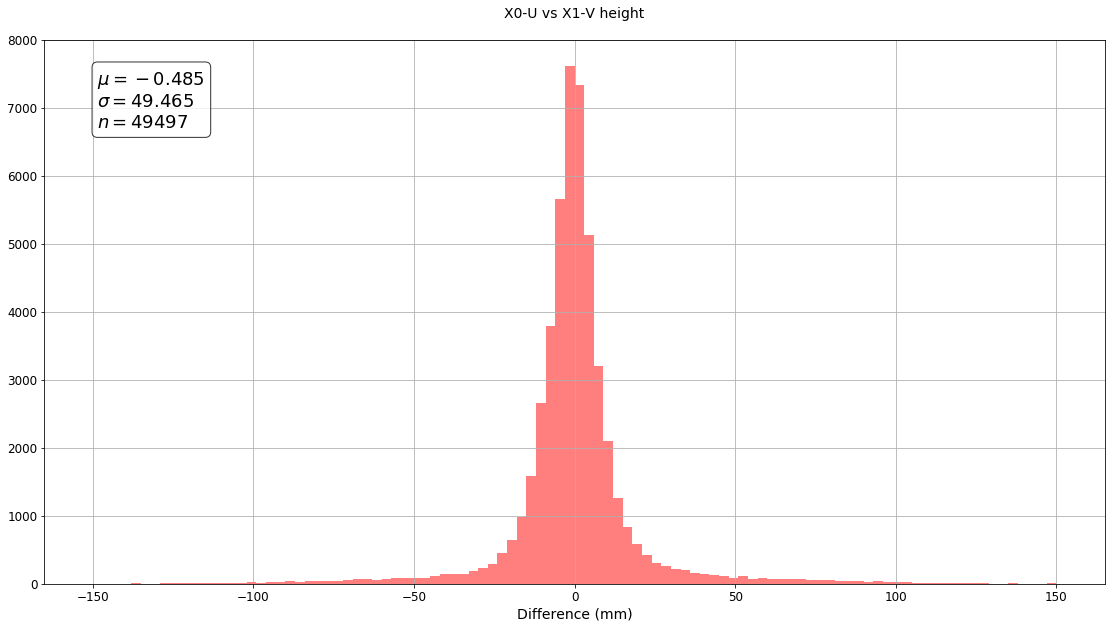

In [228]:
Y_U_plot = []
Y_V_plot = []
Y_X1_plot = []


event_hits = mc_hits[mc_hits[:,13] < events[500]]

# For each particle of a given event
for particle in event_hits:
    
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        
        X_final = {}
        Zone_final = {}
        actual = -1
        found_num = 0

        # Extract all PrHits
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[particle[8][i]] = []
                X_final[particle[8][i]].append(particle[5][i])
                Zone_final[particle[8][i]] = particle[12][i]
                actual = particle[8][i]
                found_num += 1
            else:
                X_final[actual].append(particle[5][i])
                
        if found_num < 12:
            continue
        
        m = zLays[0] / X_final[0][0]
        n = zLays[0] - (m * X_final[0][0])
        
        predicted = np.zeros(3)
        predicted[0] = (zLays[1] - n) / m 
        predicted[1] = (zLays[2] - n) / m 
        predicted[2] = (zLays[3] - n) / m 
        
        pred_h2 = predictHeight(X_final[0][0], X_final[3][0], X_final[1][0], 1, 0, 3)
        pred_h1 = predictHeight(X_final[0][0], X_final[3][0], X_final[2][0], 2, 0, 3)

        if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
            continue
        
        if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
            continue
        
        #Y_U_plot.append(X_final[1][0] - predicted[0])
        #Y_V_plot.append(X_final[2][0] - predicted[1])
        #Y_X1_plot.append(X_final[3][0] - predicted[2])
        Y_X1_plot.append(pred_h2 - pred_h1)
        #print("Range: %f Pred: %f Found: %d" % (search_range,predicted,found_bool))

#histogram(Y_U_plot, 'orange', 0.5, -500, 500, 'Real vs Predicted X in U layer', 'Difference (mm)', '')
#histogram(Y_V_plot, 'green', 0.5, -500, 500, 'Real vs Predicted X in V layer', 'Difference (mm)', '')
#histogram(Y_X1_plot, 'blue', 0.5, -500, 500, 'Real vs Predicted X in X1 layer', 'Difference (mm)', '')
histogram(Y_X1_plot, 'red', 0.5, -150, 150, 'X0-U vs X1-V height', 'Difference (mm)', '')

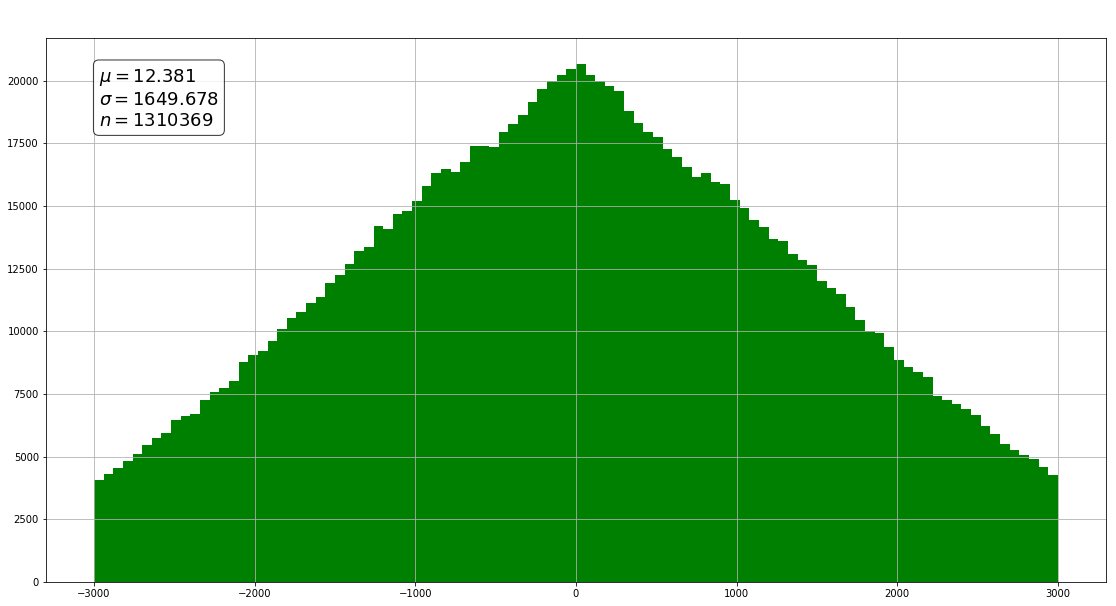

In [33]:
histogram(X_fake_data, 'green', -3000, 3000, '','','')

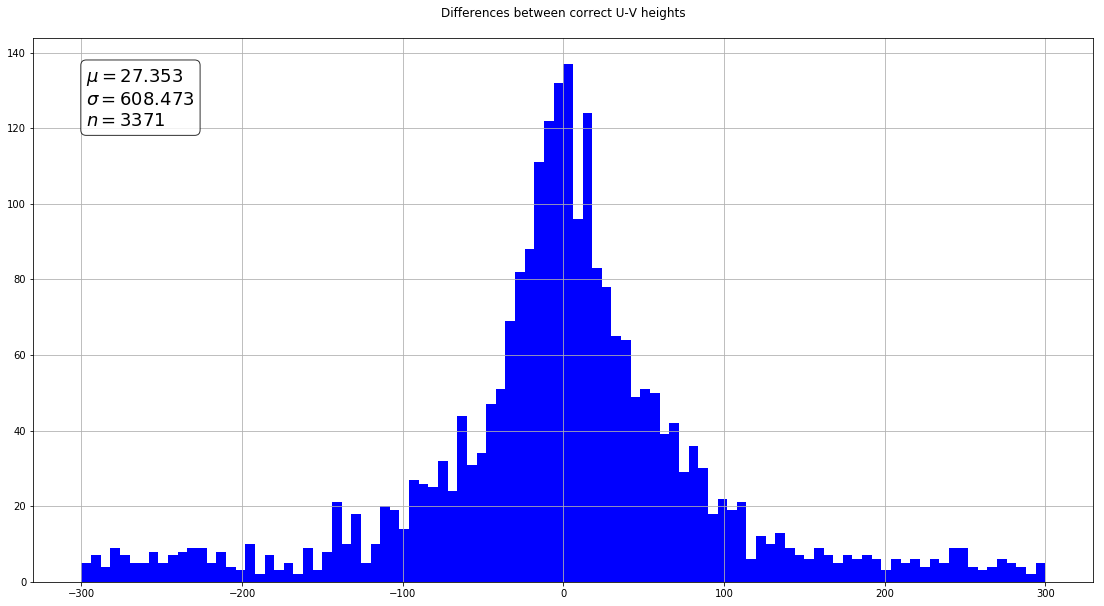

In [53]:
histogram(X_real_data, 'blue', -300, 300, 'Differences between correct U-V heights','','')

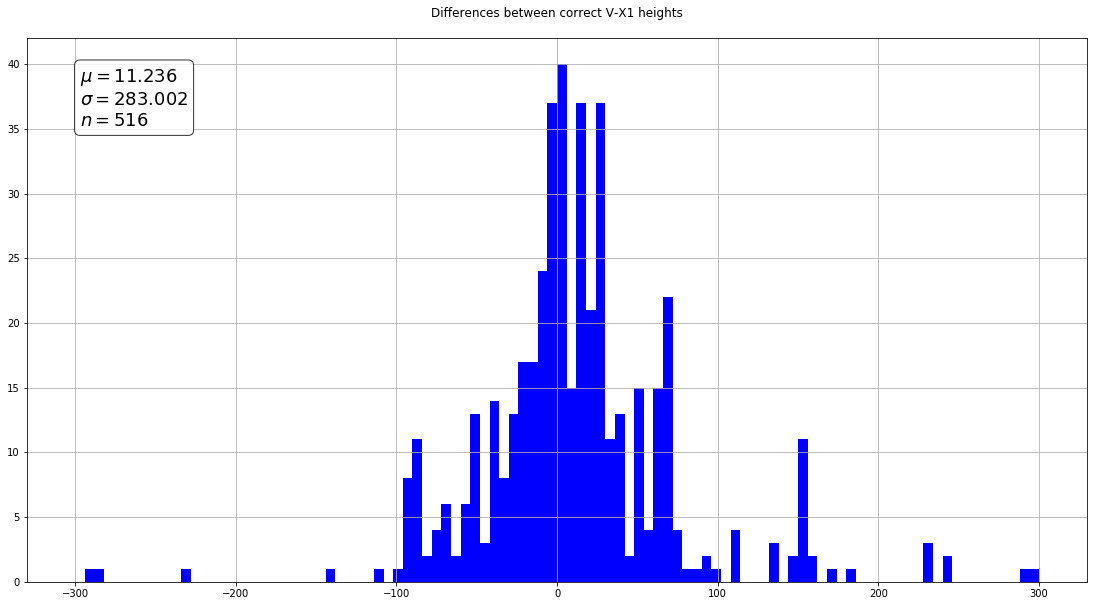

In [89]:
histogram(X_real_data, 'blue', -300, 300, 'Differences between correct V-X1 heights','','')

In [125]:
event_hits = []

for event in events[0:100]:
                    
    if event == 15863 or event == 15862:
        continue
                    
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    total_hits = 0
    for hit in particles_test_event:
        if (len(hit[5]) > 1) and not hit[0] in notValidParticles:     
            for i in range(0,len(hit[4])):
                if i > 0 and np.abs(hit[5][i] - hit[5][i-1]) < 3 and hit[8][i] == hit[8][i-1]:
                    continue
                total_hits += 1
    event_hits.append(total_hits)

In [1]:
values = [0.546512, 0.500000, 0.504065, 0.533981, 0.460317, 0.627119, 0.500000, 0.482014, 0.592593, 0.483516, 0.448276, 0.484848, 0.410714, 0.478261, 0.520548, 0.600000, 0.608696, 0.351852, 0.511111, 0.387879, 0.454545, 0.232639, 0.519608, 0.478261, 0.348485, 0.361809, 0.519231, 0.375000, 0.415730, 0.637363, 0.484848, 0.490566, 0.571429, 0.439759, 0.550847, 0.573770, 0.445946, 0.554217, 0.398649, 0.327660, 0.440559, 0.535714, 0.534483, 0.459459, 0.474074, 0.233333, 0.461538, 0.256000, 0.484536, 0.395210, 0.516129, 0.653846, 0.489130, 0.652174, 0.304688, 0.494845, 0.455882, 0.380282, 0.538462, 0.429688, 0.505882, 0.381910, 0.540984, 0.461538, 0.530303, 0.562500, 0.517241, 0.394595, 0.552632, 0.296875, 0.443548, 0.407609, 0.482759, 0.403361, 0.551402, 0.442857, 0.307692, 0.338095, 0.545455, 0.433526, 0.469388, 0.600000, 0.410714, 0.428571, 0.524272, 0.231939, 0.554622, 0.409639, 0.463415, 0.414062, 0.585714, 0.711864, 0.549180, 0.750000, 0.531915, 0.381910, 0.538462, 0.547945]
print(np.max(values))
plt.figure(figsize=(19, 10))
plt.plot([np.mean(event_hits), np.mean(event_hits)], [np.min(values), np.max(values)], c='blue', alpha = 0.4, label='Mean hits per event')
plt.plot([0, np.max(event_hits)], [np.mean(values), np.mean(values)], c='red', alpha = 0.4, label='Mean accuracy', line='--')
plt.scatter(event_hits, values, c='magenta', marker='^', s=100, alpha=0.5)
plt.yticks(list(plt.yticks()[0]) + [np.mean(values)])
plt.xticks(list(plt.xticks()[0]) + [np.mean(event_hits)])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(loc = 'upper right',prop={'size': 16})
plt.ylim([np.min(values) - 0.01,np.max(values) + 0.01])
plt.xlim([np.min(event_hits) - 100,np.max(event_hits) + 100])
plt.xlabel('\nNumber of hits in event', fontsize=14)
plt.ylabel('Accuracy\n', fontsize=14)
plt.show()

NameError: name 'np' is not defined